In [3]:
!CXXFLAGS+=-stdlib=libc++ maturin develop --release

🔗 Found pyo3 bindings
🐍 Found CPython 3.11 at /Users/josh/josh/projects/tech/riversim/.venv/bin/python
💻 Using `MACOSX_DEPLOYMENT_TARGET=10.7` for x86_64-apple-darwin by default
   Compiling riversim v0.1.0 (/Users/josh/josh/projects/tech/riversim)
    Finished release [optimized] target(s) in 11.70sversim                    
📦 Built wheel for CPython 3.11 to /var/folders/w9/c8qym84j2pg4fjvx_bzr84bc0000gn/T/.tmpMvXrDw/riversim-0.1.0-cp311-cp311-macosx_10_7_x86_64.whl
🛠 Installed riversim-0.1.0


In [1]:
import contextplot
import matplotlib
import tqdm

import riversim

contextplot.set_defaults()

example = 'advection_1d'
v_max = 0.03
# example = 'singularity_1d'
# v_max = 0.5

num_cells = 30
solver = getattr(riversim, example)(num_cells, 20)

dt = 0.0001
# dt = 0.0007

with contextplot.context_video(f'{example}.mp4', 1, size_inches=(8, 3), frame_rate_hz=10) as cv:
    for step in tqdm.tqdm(range(400)):
        if step % 10 == 0:
            with cv.next_frame() as cp:
                z_lattice = solver.z_lattice
                x_vertices = solver.grid.x_axis.vertices
                pressure = solver.pressure

                # print((pressure[5, 0, 1, 1] - pressure[5, 0, 0, 1]) / (z_lattice[5, 0, 1] - z_lattice[5, 0, 0]))

                poly_verts = []
                pressures = []
                for i in range(z_lattice.shape[0] - 1):
                    for j in range(z_lattice.shape[2] - 1):
                        poly_verts.append([
                            [x_vertices[i], z_lattice[i, 0, j]],
                            [x_vertices[i + 1], z_lattice[i + 1, 0, j]],
                            [x_vertices[i + 1], z_lattice[i + 1, 0, j + 1]],
                            [x_vertices[i], z_lattice[i, 0, j + 1]],
                        ])
                        pressures.append(pressure[i, 0, j, 1])
                poly_collection = matplotlib.collections.PolyCollection(
                    poly_verts, closed=True, array=pressures, cmap=matplotlib.cm.viridis, edgecolors='black', linewidth=0.5)
                outs = cp.ax_raw.add_collection(poly_collection)

                # p_all = []
                # x_all = []
                # z_all = []
                # for i, x in enumerate(solver.grid.x_axis.vertices):
                #     p_all.extend(pressure[i, 0])
                #     x_all.extend([x] * len(pressure[i, 0]))
                #     z_all.extend(z_lattice[i, 0])
                # outs = cp.ax_raw.scatter(x_all, z_all, c=p_all, s=40, alpha=0.8, linewidth=0)
                _ = cp.figure.colorbar(outs)

                # cp.ax.axis('equal')
                cp.ax.set(xlim=[solver.grid.x_axis.vertices[0], solver.grid.x_axis.vertices[-1]], ylim=[0, 1.5])

                # cp.next()
                # velocity = solver.velocity
                # cp.ax.plot(solver.grid.x_axis.centers, velocity[:, 0, ])
        solver.step(dt)

100%|██████████| 400/400 [01:01<00:00,  6.46it/s]


In [2]:
(pressure[5, 0, 1, 1] - pressure[5, 0, 0, 1]) / (z_lattice[5, 0, 1] - z_lattice[5, 0, 0])

-2539.701243732179

(100, 2, 20, 2, 3)

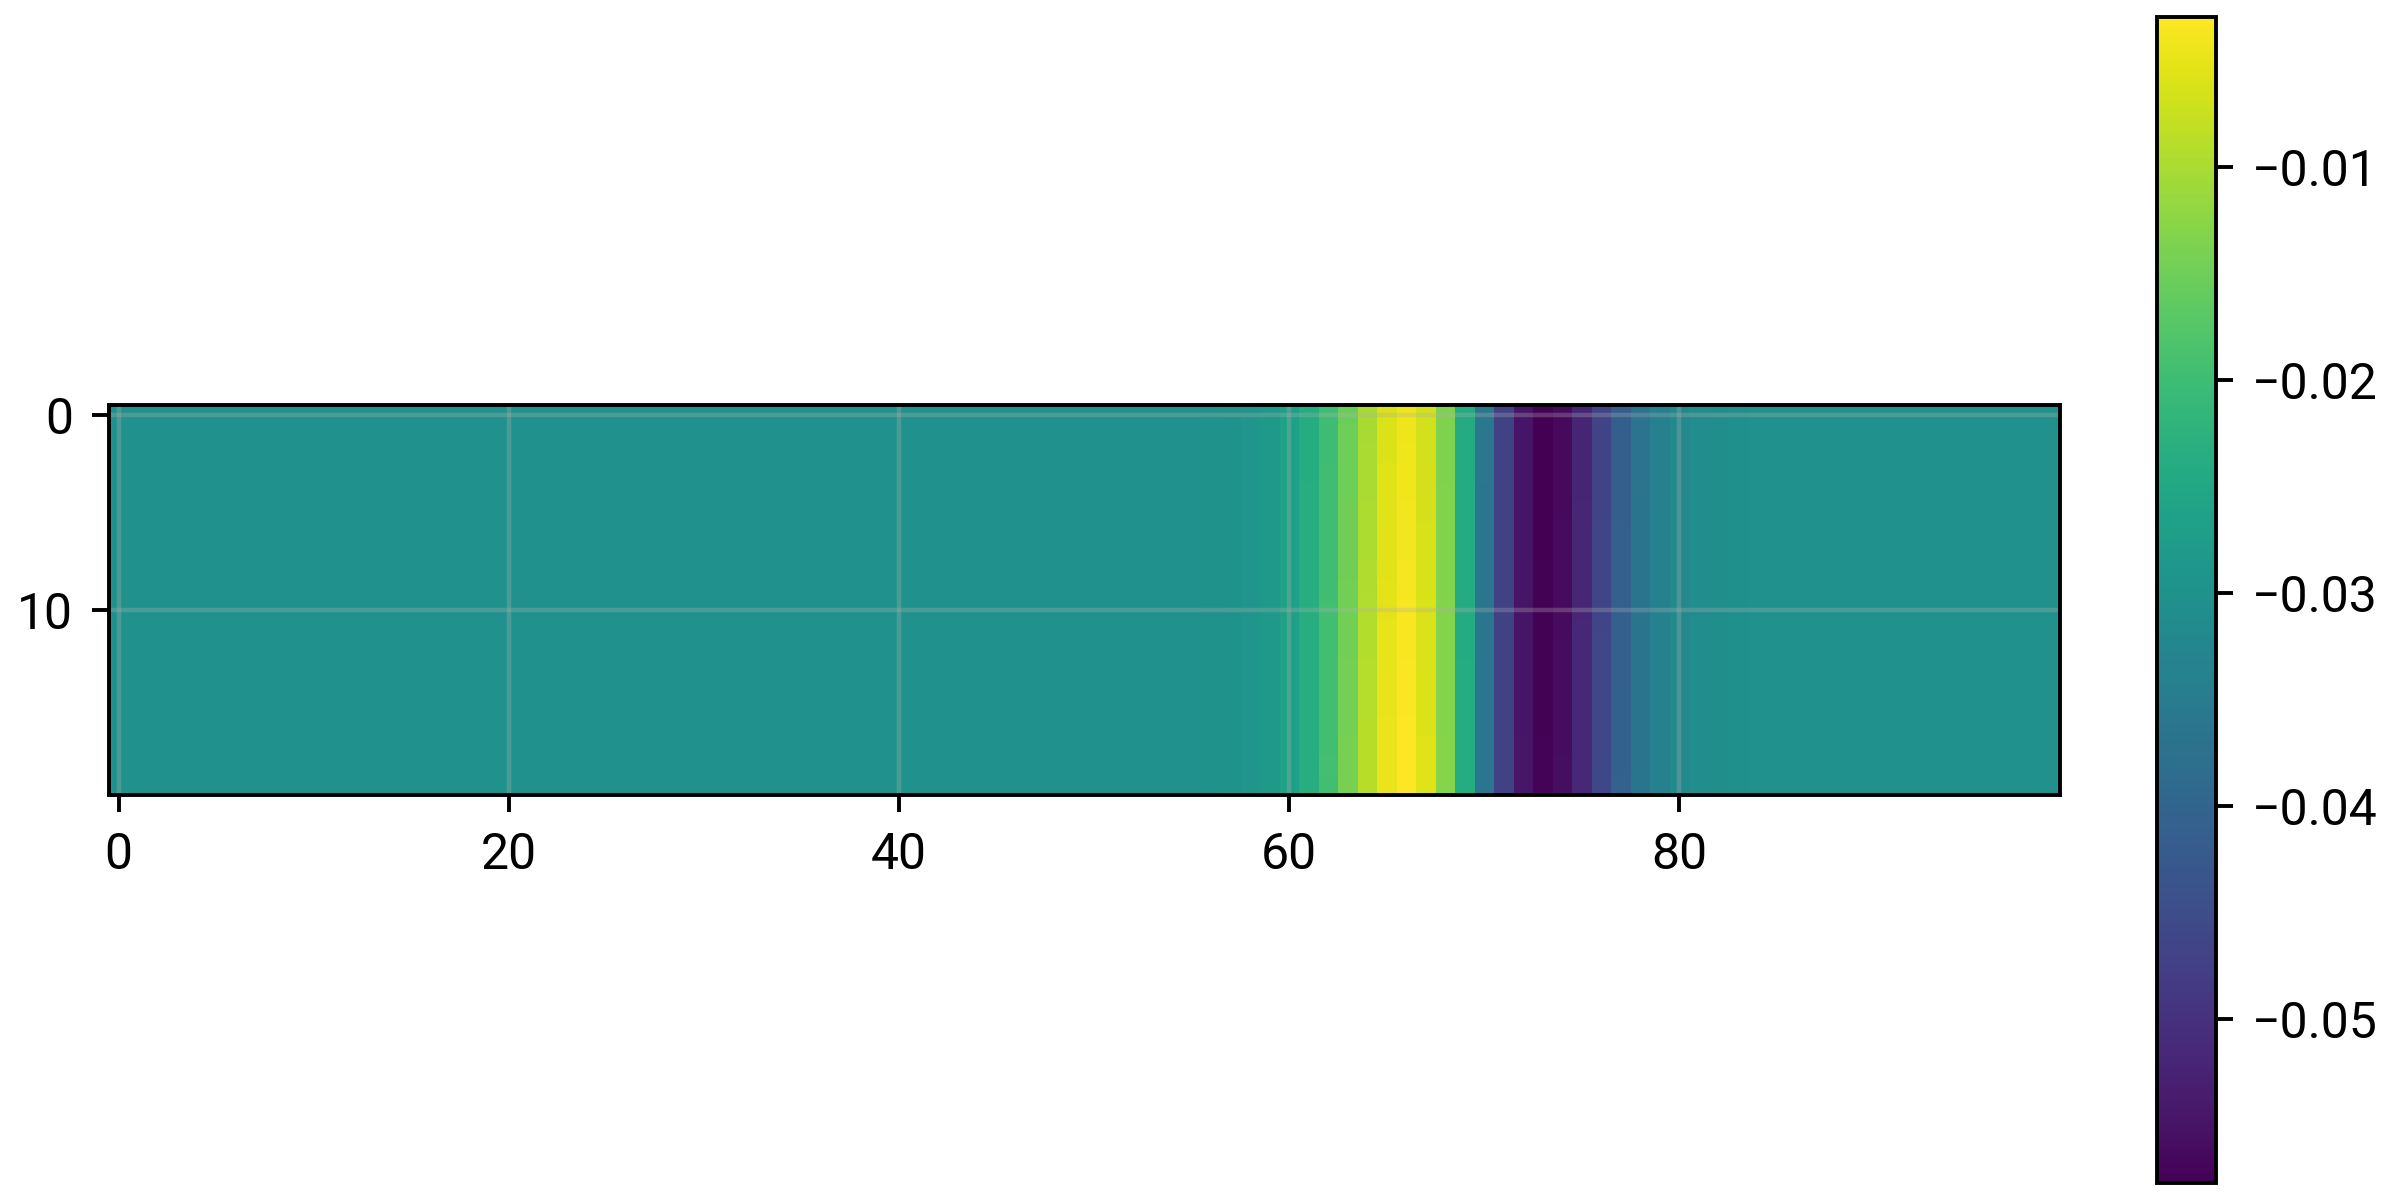

In [12]:
import contextplot
import numpy as np

contextplot.set_defaults()

import riversim

num_cells = 100
v_max = 0.03
courant_dt = 1 / num_cells / v_max

solver = riversim.advection_1d(num_cells, 20)
solver.step(courant_dt / 2 / 1000)
solver.velocity.shape
with contextplot.context_plot() as cp:
    outs = cp.ax_raw.imshow(solver.velocity[:, 0, :, 0, 0].T)
    _ = cp.figure.colorbar(outs)

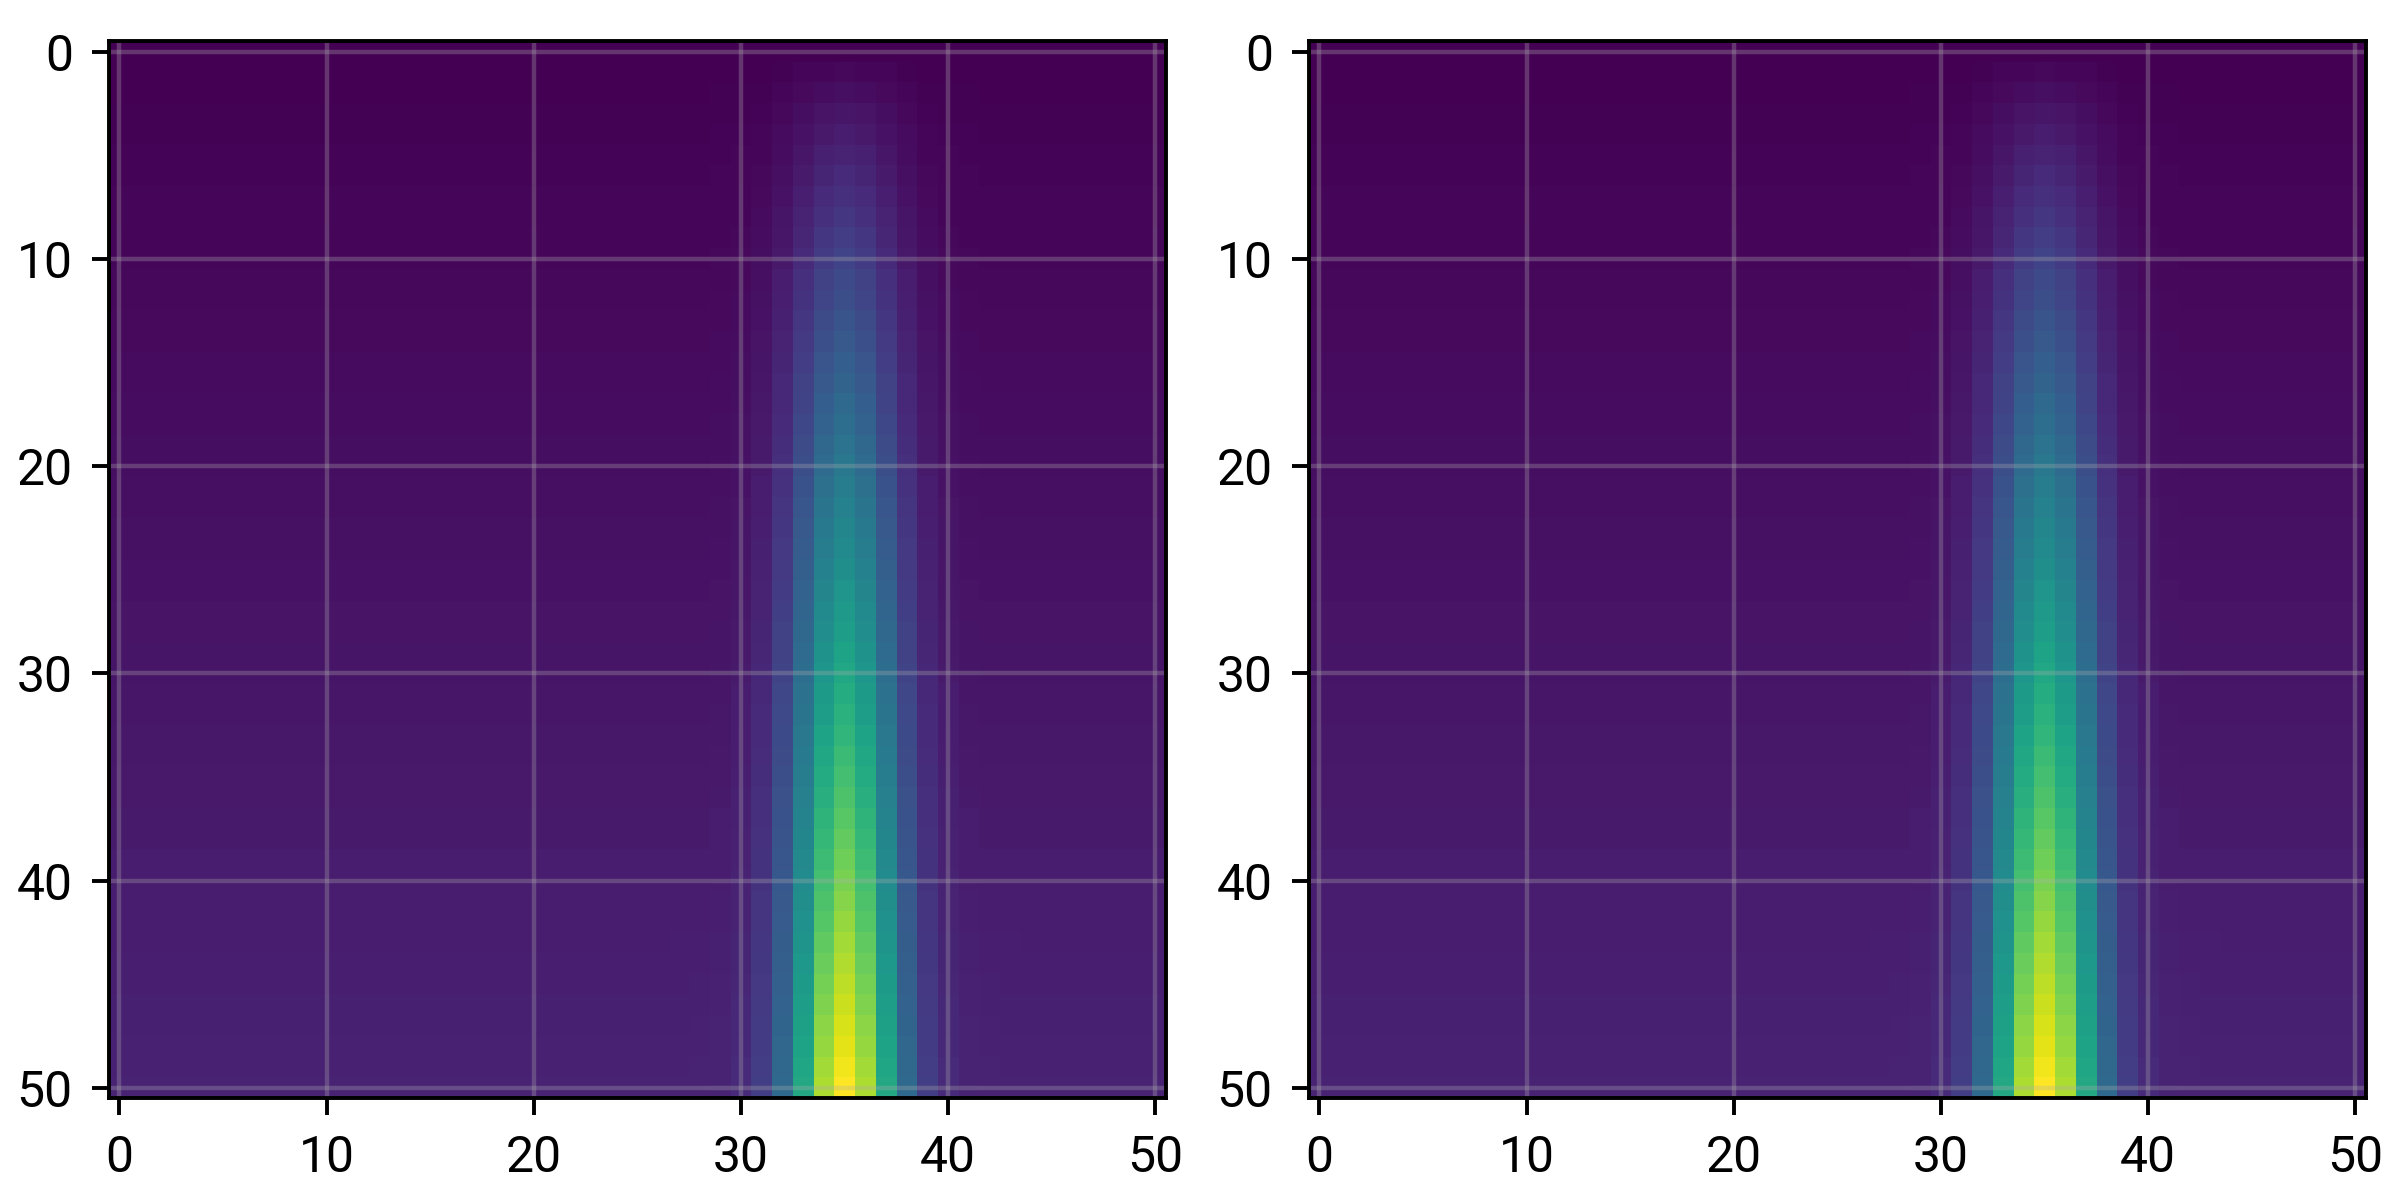

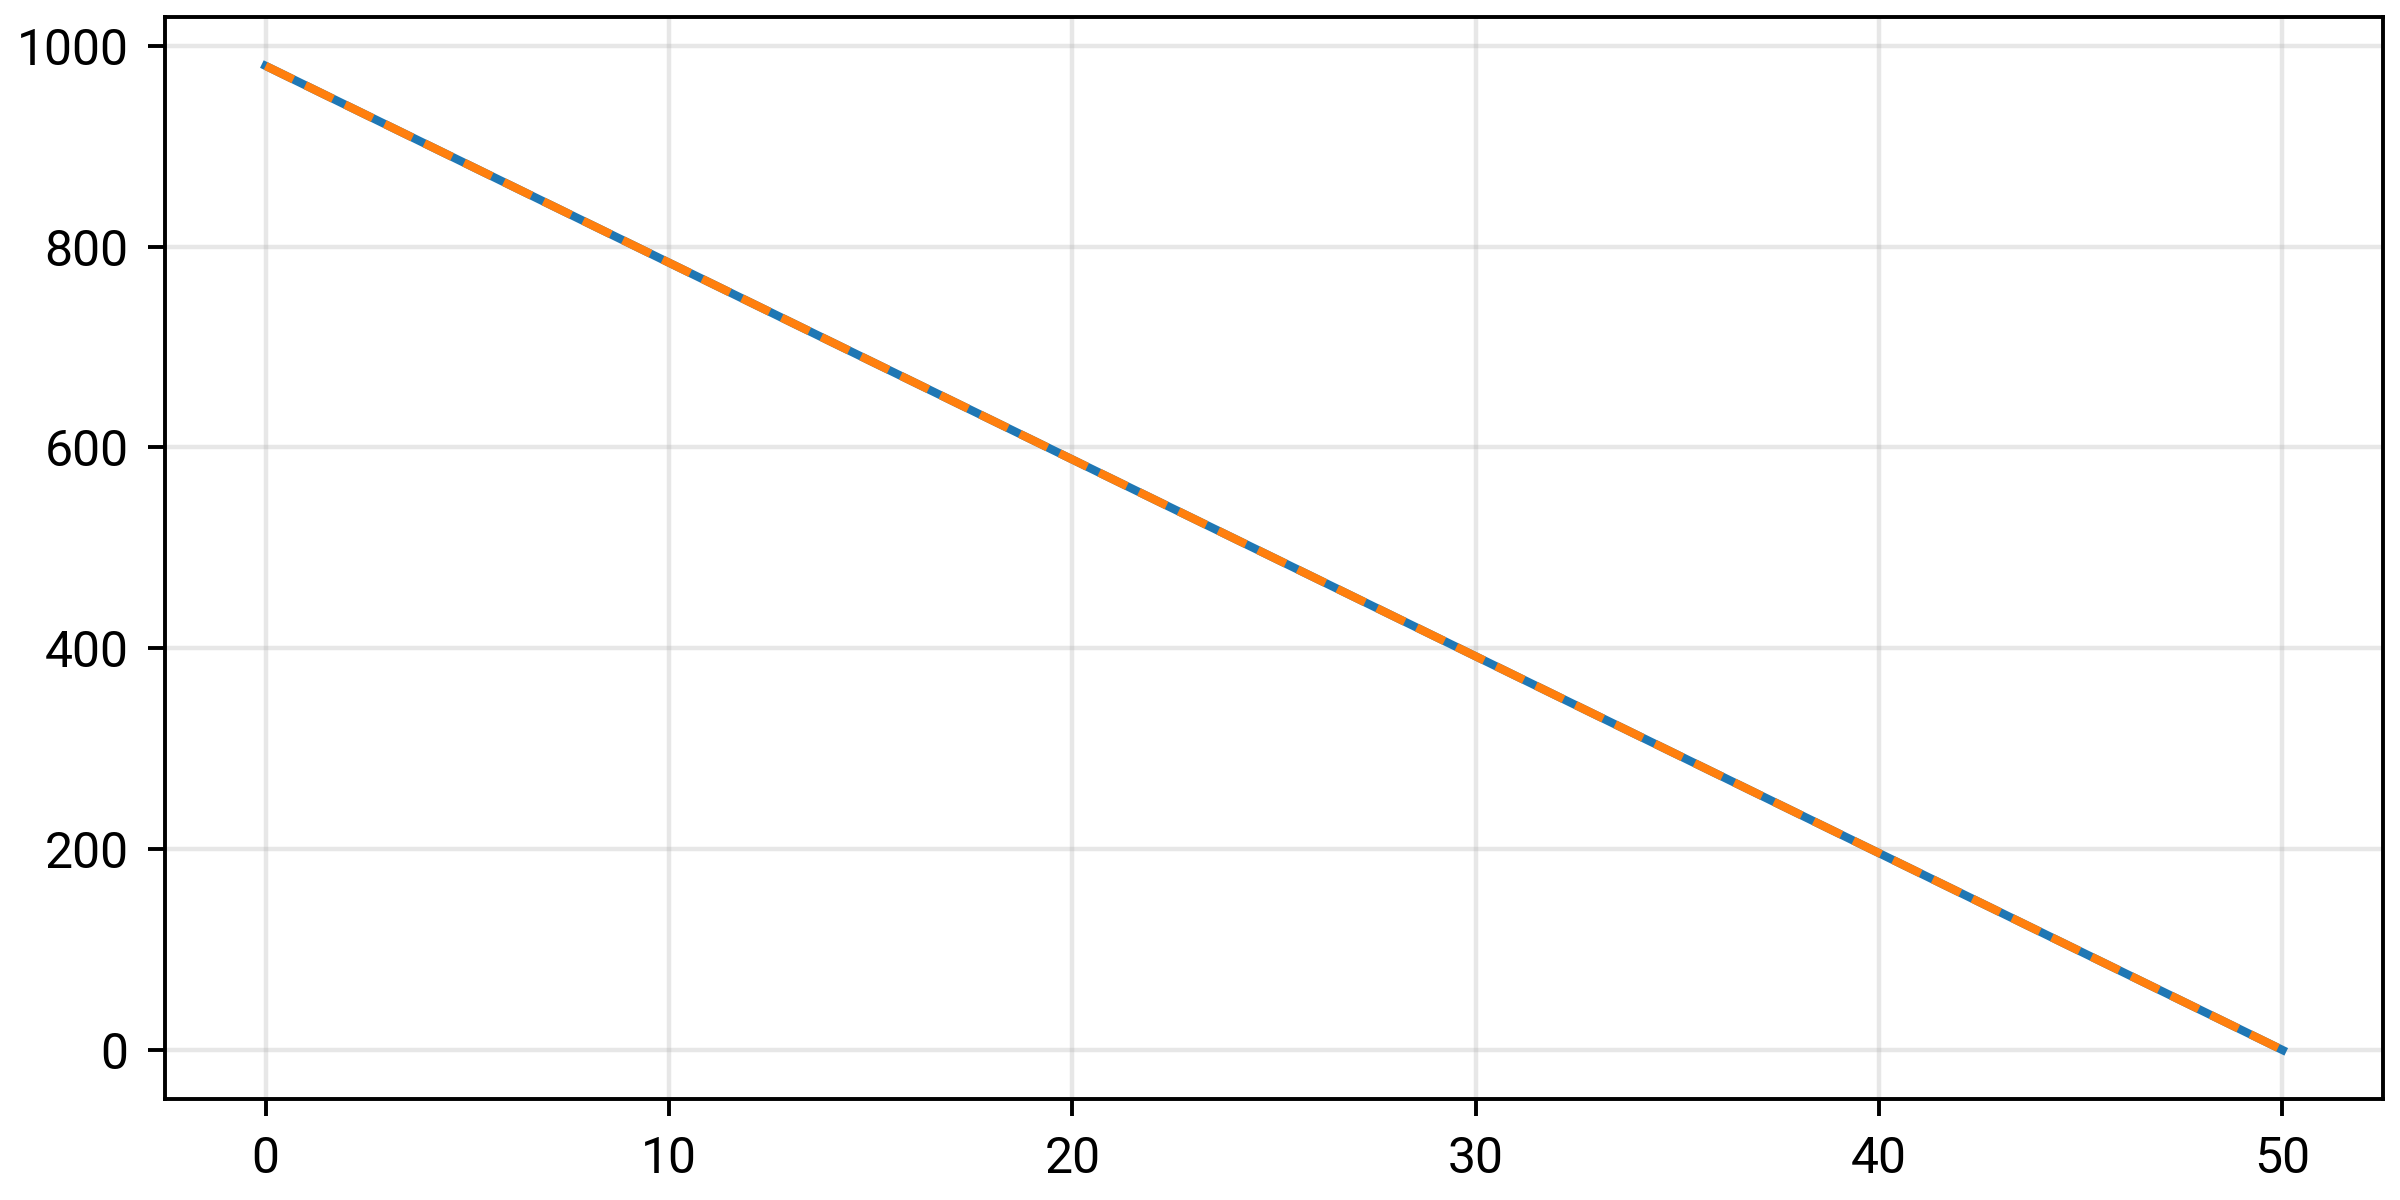

In [4]:
from joshpyutil import mpl

import riversim

solver = riversim.advection_1d(50, 50)

with mpl.autoplot(1, 2) as ap:
    _ = ap.ax.imshow(solver.pressure[:, 1, ::-1].T)

    ap = ap.next()
    _ = ap.ax.imshow(solver.pressure[:, 1, ::-1].T)

with mpl.autoplot() as ap:
    _ = ap.plot(solver.pressure[5, 0, :])
    _ = ap.plot(solver.hydrostatic_pressure[5, 0, :], '--')
    # _ = ap.plot(solver.pressure[5, 1:, 10] - solver.pressure[5, :-1, 10])
    # _ = ap.plot(solver.pressure[1:, 10, 10] - solver.pressure[:-1, 10, 10])

# (solver.pressure[4, 10, 10] - 2 * solver.pressure[5, 10, 10] + solver.pressure[6, 10, 10]+
# solver.pressure[5, 9, 10] - 2 * solver.pressure[5, 10, 10] + solver.pressure[5, 11, 10]+
# solver.pressure[5, 10, 9] - 2 * solver.pressure[5, 10, 10] + solver.pressure[5, 10, 11])